# Tutorial for running and analysing MBIPMs

## Notes

General conventions:
* Global variables are written in capitals, e.g. INITIAL_BIOMASS.
* The dimensions of the objects are indicated by the number of repeats of the first letter of the variable name

  e.g.
  
  `scalar = 1,`

  `vvector = [1, 2, ...],`
  
  `mmmatrix = [[1,2], [3,4]],`
  
  `ttttensor for dimensions > 2.`

In [2]:
print("lol")

lol


In [1]:
##############
## INITIATE ##
##############

## Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import yaml

## Import modules
from f_YEM_V1_14_2025_10_10 import pdf
from f_YEM_V1_14_2025_10_10 import f_normal
from f_YEM_V1_14_2025_10_10 import YellowstoneEcosystemModel
from f_YEM_V1_14_2025_10_10 import plot_model

## Set the device to MPS if available
device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")
device = "cpu" # Force cpu for now
print(device)

## Figure parameters
plt.rcParams['figure.dpi'] = 100
FIGSIZE = (6,4)
custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'axes.facecolor':'whitesmoke'}
sns.set_theme(style="ticks", rc=custom_params)

## Font
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 14
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

#
###

Matplotlib is building the font cache; this may take a moment.


cpu


## Load and simulate the model

In [3]:
####################
## INITIATE MODEL ##
####################

## Model
model = YellowstoneEcosystemModel("parameters-aposteriori-V1-14-2025-10-13.yaml")

#
###

In [ ]:
###############
## RUN MODEL ##
###############

## Initiate parameters
t_max = 200 # Maximum time of the simulation

## Hyperparameters
INITIAL_BIOMASS = torch.tensor(15*1e9, dtype=torch.float64) # Initial biomass in each unstructured compartment 
IINITIAL_POPULATION_SIZES = torch.tensor([1*100000, 1*100000, 1*10000, 1*1000, 1*30, 1*30], dtype=torch.float64)
ZZMAX = torch.tensor([100, 100, 500, 1000, 200, 300], dtype=torch.float64) # Maximum phenotype values (kg) for each species (i.e. willow, aspen, elk, bison, wolves, cougars)
ZZZ_LEN = 500 # Length of phenotype vector

## Simulation
t0 = time.time()
predictions = model.simulate(t_max=t_max,
                             Dt = INITIAL_BIOMASS, # Biomass of organic matter at t = 0
                             Bt = INITIAL_BIOMASS, # Biomass of decomposers at t = 0
                             Pt = INITIAL_BIOMASS, # Biomass of nutrients at t = 0
                             Gt = INITIAL_BIOMASS, # Biomass of grass at t = 0
                             NNt = IINITIAL_POPULATION_SIZES, # Initial population sizes
                             zzmax = ZZMAX,
                             zzz_len = ZZZ_LEN
                            )
#
## Collect results (time series of variables)
zzz, tt, DDt, BBt, PPt, GGt, NNNt, NNNNzt, ttotal_biomass = predictions
# dim(XXt) = (times)
# dim(NNNt) = (times, species)
# dim(NNNzt) = (times, species, phenotype)
tf = time.time()
print(f"{tf-t0:.2f}s")

## Visualise
plot_model(predictions)

#
###

108.06s


In [8]:
####################################
## FORMAT PREDICTIONS FOR FIGURES ##
####################################

## Format output (time, species, phenotype) --> (species, time, phenotype)
zzz, tt, DDt, BBt, PPt, GGt, NNNt, NNNNzt, ttotal_biomass = predictions
NNNNzt_new = []
for i in range(6):
    NNNzt_new = []
    for NNNzt in NNNNzt:
        NNNzt_new += [NNNzt[i].clone()]
    NNNNzt_new += [torch.stack(NNNzt_new)]
NNNNzt = torch.stack(NNNNzt_new)

#
###

## Change parameters

In [25]:
#############################
## ACCESS MODEL PARAMETERS ##
#############################

## Check parameter values
print(model.ddelta)
ddelta = model.ddelta # To save initial parameters

## Change values, e.g. 
model.ddelta = model.ddelta * 1.1
print(model.ddelta)

## Reset values
model.ddelta = ddelta
print(model.ddelta)

#
###

tensor([0.3113, 0.0347, 0.9119, 1.1339, 7.4235, 3.9801], dtype=torch.float64)
tensor([0.3424, 0.0382, 1.0031, 1.2473, 8.1659, 4.3781], dtype=torch.float64)
tensor([0.3113, 0.0347, 0.9119, 1.1339, 7.4235, 3.9801], dtype=torch.float64)


In [ ]:
#################
## MODEL SETUP ##
#################

## Initiate parameters
t_max = 200 # Maximum time of the simulation

## Hyperparameters
INITIAL_BIOMASS = torch.tensor(15*1e9, dtype=torch.float64) # Initial biomass in each unstructured compartment 
IINITIAL_POPULATION_SIZES = torch.tensor([1*100000, 1*100000, 1*10000, 1*1000, 1*30, 1*30], dtype=torch.float64)
ZZMAX = torch.tensor([100, 100, 500, 1000, 200, 300], dtype=torch.float64) # Maximum phenotype values (kg) for each species (i.e. willow, aspen, elk, bison, wolves, cougars)
ZZZ_LEN = 500 # Length of phenotype vector

#
###

In [23]:
#######################
## PARAMETERS SWEEPS ##
#######################

## Parameter scaling
SSCALING = [0.5, 0.75, 1.0, 1.5,  2.0]
PARAMETER_ANCHOR = model.phi_DB

## Collect 
ppredictions = []
for scaling in SSCALING:

    ## Change parameter
    model.phi_DB = PARAMETER_ANCHOR * scaling
    print(model.phi_DB)
           
    ## Simulation
    t0 = time.time()
    predictions = model.simulate(t_max=t_max, 
                                 Dt = INITIAL_BIOMASS, Bt = INITIAL_BIOMASS, 
                                 Pt = INITIAL_BIOMASS, Gt = INITIAL_BIOMASS, 
                                 NNt = IINITIAL_POPULATION_SIZES, 
                                 zzmax = ZZMAX, zzz_len = ZZZ_LEN)    
    zzz, tt, DDt, BBt, PPt, GGt, NNNt, NNNNzt, ttotal_biomass = predictions
    tf = time.time()
    print(f"{tf-t0:.2f}s")

    ## Store predictions
    ppredictions += [NNNt]        
    
#
###

tensor(0.1003, dtype=torch.float64)
9.40s
tensor(0.1505, dtype=torch.float64)
13.52s
tensor(0.2007, dtype=torch.float64)
10.05s
tensor(0.3010, dtype=torch.float64)
9.85s
tensor(0.4014, dtype=torch.float64)
10.18s


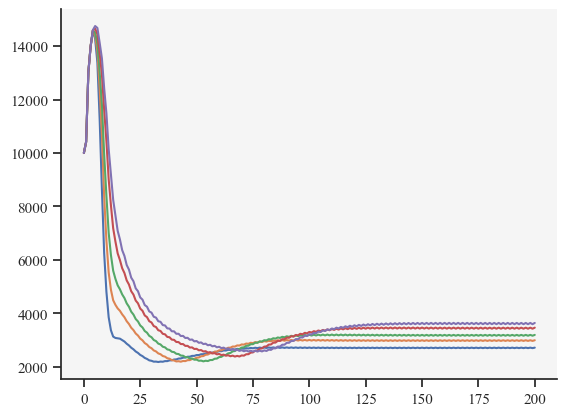

In [24]:
###########################
## VISUALISE SENSITIVITY ##
###########################

## Convert to tensor
time_series_sensitivity = torch.stack(ppredictions)
time_series_sensitivity = torch.transpose(time_series_sensitivity, 1, 0)

## Visualise
plt.plot(time_series_sensitivity[:,:,2])
plt.show()

#
###

## Simulate from equilibrium

In [30]:
######################
## FIND EQUILIBRIUM ##
######################

## Initiate parameters
t_max_0 = 500
t_max_1 = 500

## Period 0
t0 = time.time()
predictions_0 = model.simulate(t_max=t_max_0, 
                             Dt = INITIAL_BIOMASS, Bt = INITIAL_BIOMASS, 
                             Pt = INITIAL_BIOMASS, Gt = INITIAL_BIOMASS, 
                             NNt = IINITIAL_POPULATION_SIZES, 
                             zzmax = ZZMAX, zzz_len = ZZZ_LEN)    
zzz, tt, DDt, BBt, PPt, GGt, NNNt, NNNNzt, ttotal_biomass = predictions_0
tf = time.time()
print(f"{tf-t0:.2f}s")

## Save initial conditions
zzz, tt, DDt, BBt, PPt, GGt, NNNt, NNNNzt, ttotal_biomass = predictions_0
Dt_0 = DDt[-1].clone().detach()
Bt_0 = BBt[-1].clone().detach()
Pt_0 = PPt[-1].clone().detach()
Gt_0 = GGt[-1].clone().detach()
NNt_0 = NNNt[-1].clone().detach()
NNNzt_0 = NNNNzt[-1].clone().detach()

#
###

24.38s


29.59s


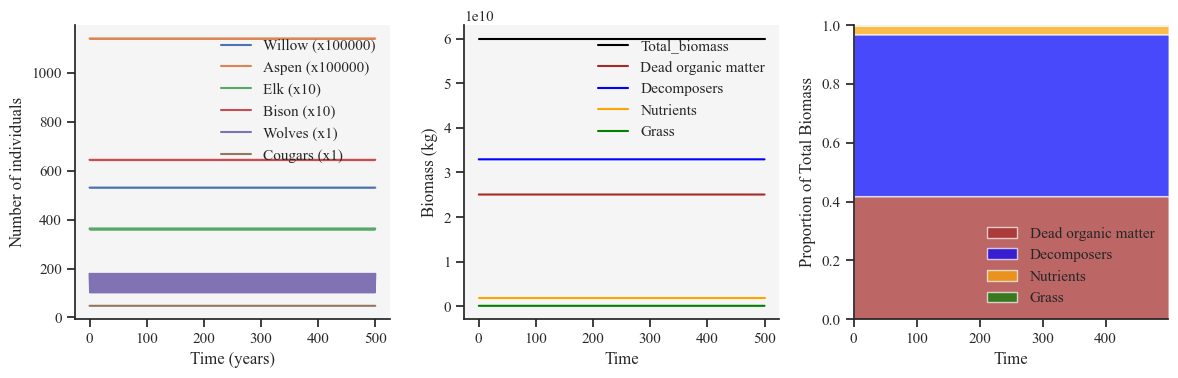

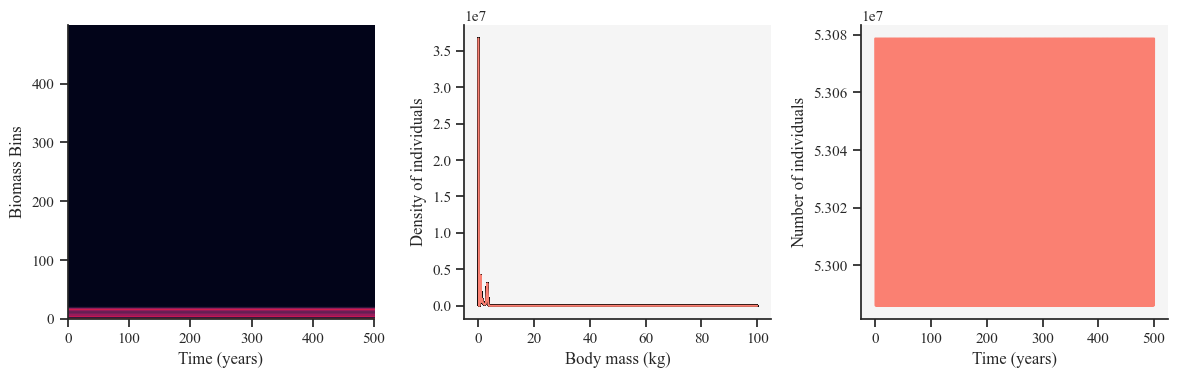

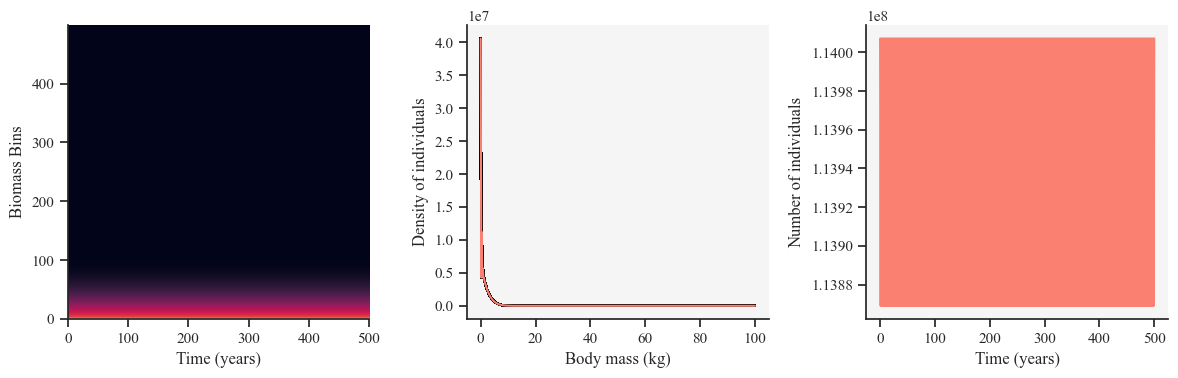

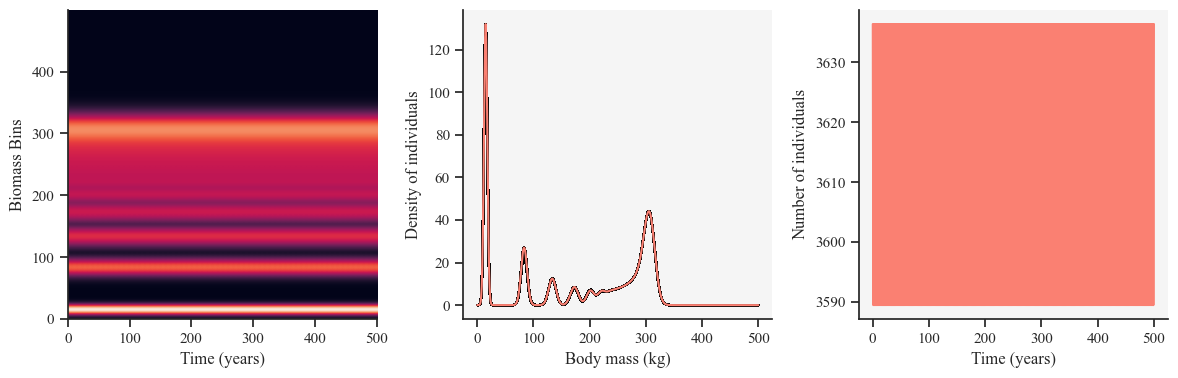

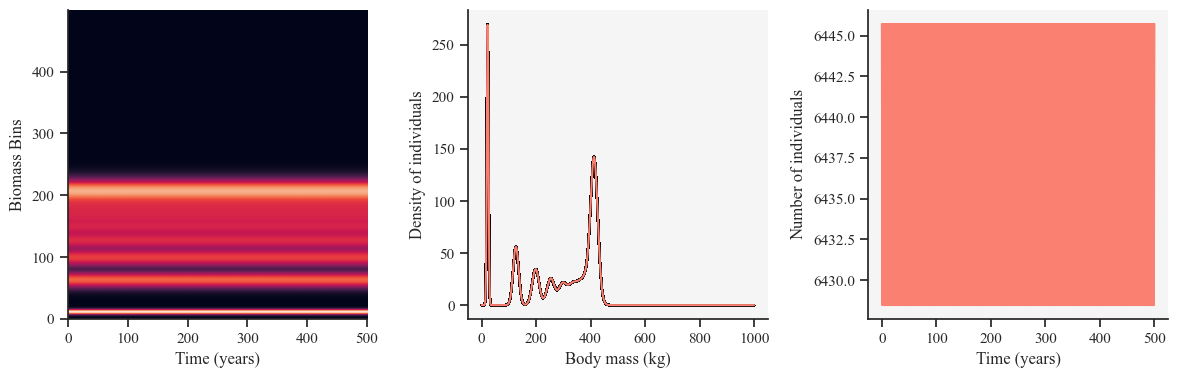

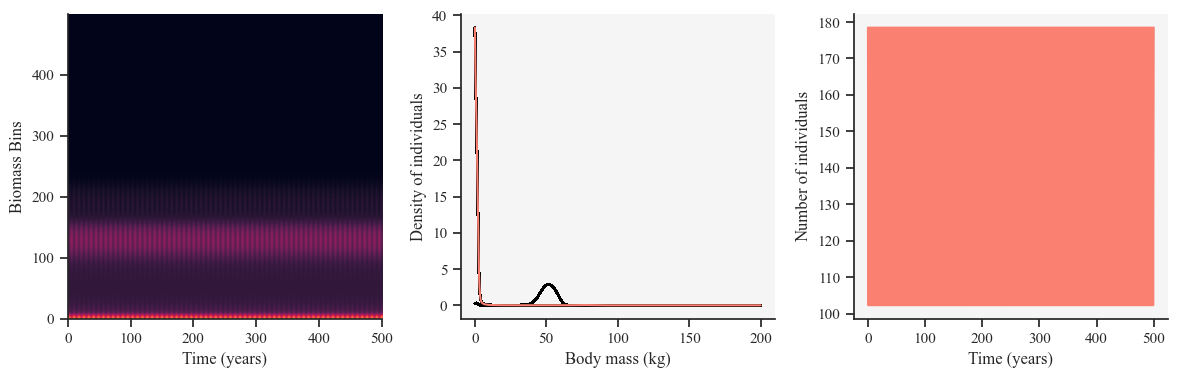

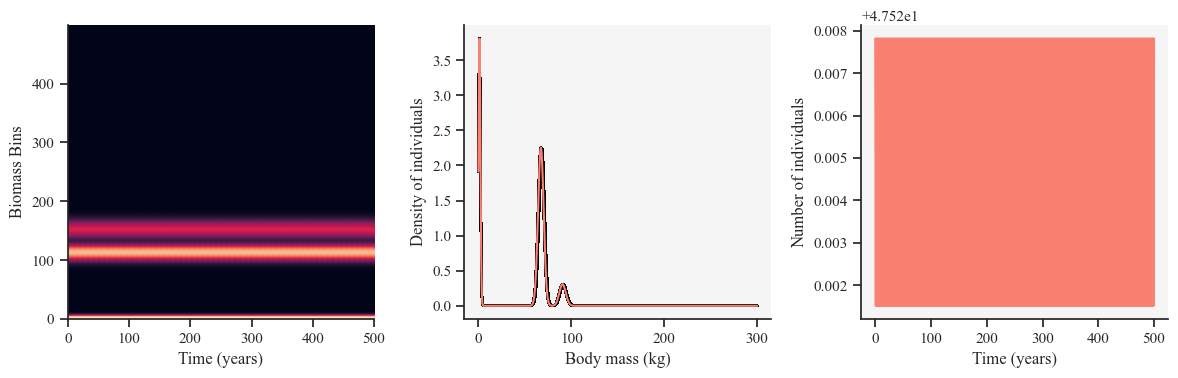

In [32]:
###############################
## SIMULATE FROM EQUILIBRIUM ##
###############################

## Period 1
t0 = time.time()
predictions_1 = model.simulate(t_max=t_max_1,
                             Dt = Dt_0,
                             Bt = Bt_0,
                             Pt = Pt_0,
                             Gt = Gt_0,
                             NNt = NNt_0,
                             NNNzt = NNNzt_0,
                             zzmax = ZZMAX,
                             zzz_len = ZZZ_LEN
                            )
zzz, tt, DDt, BBt, PPt, GGt, NNNt, NNNNzt, ttotal_biomass = predictions_1
tf = time.time()
print(f"{tf-t0:.2f}s")

## Visualise
plot_model(predictions_1)

#
###